In [1]:
# Set up logging to monitor the execution of the program.
import logging

logger = logging.getLogger("qstack")

handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)


In [2]:
# This example demonstrates the compilation of quantum programs using qstack.
# Compilation is the process of transforming a high-level quantum program into a lower-level representation suitable for execution.
# The Toy layer is a simplified abstraction layer for quantum operations, useful for prototyping and testing.
# It uses gates with names that reflect the intention (e.g., Flip) instead of the mathematical operation (e.g., X).
# It provides basic quantum gates and operations to define quantum programs.
import qstack

program = None

In [3]:
%%qstack
@instruction-set: toy

allocate q1:
  allocate q2 q3:
    mix q2
    flip q3
  measure
  ?? fix(q=q1)
measure

[Kernel(target=QubitId(value='q1'), instructions=(Kernel(target=QubitId(value='q2'), instructions=(Kernel(target=QubitId(value='q3'), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q2')], parameters={}), QuantumInstruction(name='flip', targets=[QubitId(value='q3')], parameters={})), callback=None),), callback=ClassicInstruction(name='fix', parameters={'q': 'q1'})),), callback=None)]

In [4]:
## Prepare the classical callbacks that is needed for the program.
from qstack import Kernel
from qstack.instruction_sets.toy import Flip

# Define a classical callback function for flipping a qubit's state.
def fix(context, *, q):
    return Kernel(target=[], instructions=[Flip(q)])


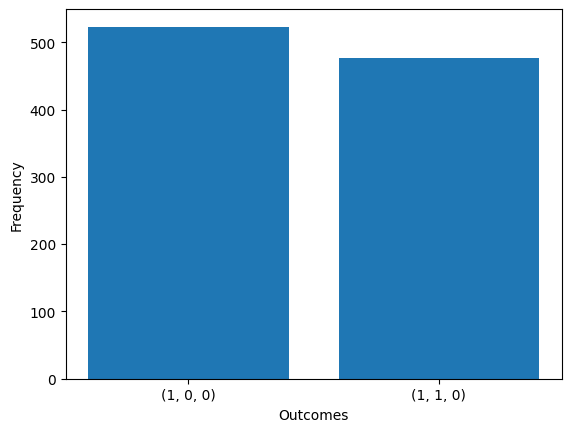

In [5]:
# Set up a local quantum machine to execute the program.
# Each machine in qstack is created to target a specific stack or instruction set.
# This ensures that the machine can correctly interpret and execute the program's instructions.
from qstack.machine import local_machine_for, create_callbacks

original = program
callbacks = create_callbacks(fix)
machine = local_machine_for(original.instruction_set, callbacks)

# Evaluate the original program and plot the resulting histogram.
machine.eval(original).plot_histogram()


In [6]:
# Compile the program using the ToyCompiler.
# The ToyCompiler transforms the program into a lower-level representation.
from qstack.compilers.toy2cliffords import ToyCompiler

compiler = ToyCompiler()
compiled, compiled_callbacks = compiler.compile(original, callbacks)

# Print the compiled program to see the transformed representation.
print(compiled)


2025-06-27 16:53:31,882 - WARNING - Instruction skew has no handler.


@instruction-set: cliffords-min

allocate q1:
  allocate q2:
    allocate q3:
      h q2
      x q3
    measure
  measure
  ?? _toy2cliffords_:fix(q=q1)
measure


In [7]:
# Attempt to evaluate the compiled program using the original machine.
# This will fail because the machine is configured for the original stack.
try:
    machine.eval(compiled).plot_histogram()
except Exception as e:
    print(e)
    print("This is expected, as the machine is for the original stack...")


Invalid instruction: h q2
This is expected, as the machine is for the original stack...


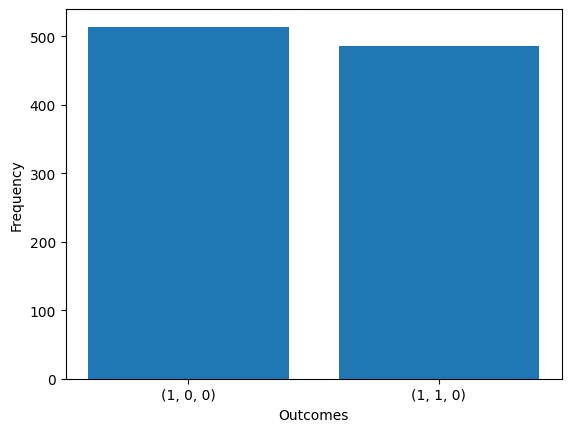

In [8]:
# Set up a new machine for the compiled program's stack and evaluate it.
machine = local_machine_for(compiled.instruction_set, callbacks=compiled_callbacks)
machine.eval(compiled).plot_histogram()


In [9]:
# Compile the program further using the TrivialRepetitionCompiler.
# This compiler applies a simple repetition code for error correction.
from qstack.compilers.rep3_trivial import TrivialRepetitionCompiler

compiler = TrivialRepetitionCompiler()
rep3, rep3_callbacks = compiler.compile(compiled, compiled_callbacks)

# Print the program after applying the repetition code.
print(rep3)


2025-06-27 16:53:36,273 - WARNING - Instruction z has no handler.
2025-06-27 16:53:36,275 - WARNING - Instruction cz has no handler.
2025-06-27 16:53:36,277 - WARNING - Instruction cx has no handler.
2025-06-27 16:53:36,278 - WARNING - Instruction y has no handler.


@instruction-set: cliffords-min

allocate q1.0:
  allocate q1.1:
    allocate q1.2:
      ---
      allocate q2.0:
        allocate q2.1:
          allocate q2.2:
            allocate q3.0:
              allocate q3.1:
                allocate q3.2:
                  ---
                  h q2.0
                  h q2.1
                  h q2.2
                  ---
                  x q3.0
                  x q3.1
                  x q3.2
                measure
              measure
            measure
            ?? decode
          measure
        measure
      measure
      ?? decode
      ?? _rep3-trivial_:_toy2cliffords_:fix(q=q1)
    measure
  measure
measure
?? decode


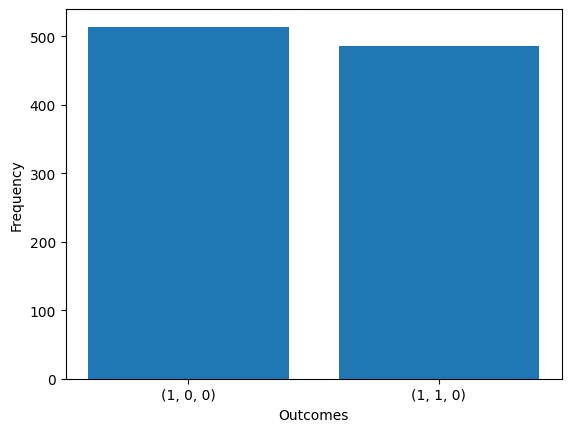

In [10]:
# Set up a machine for the repetition-coded program and evaluate it.
machine = local_machine_for(rep3.instruction_set, callbacks=rep3_callbacks)
machine.eval(rep3).plot_histogram()


In [11]:
# Apply the repetition code again to the program.
rep3bis, rep3bis_callbacks = compiler.compile(rep3, rep3_callbacks)

# Print the program after the second application of the repetition code.
print(rep3bis)


@instruction-set: cliffords-min

---
allocate q1.0.0:
  allocate q1.0.1:
    allocate q1.0.2:
      allocate q1.1.0:
        allocate q1.1.1:
          allocate q1.1.2:
            allocate q1.2.0:
              allocate q1.2.1:
                allocate q1.2.2:
                  ---
                  ---
                  allocate q2.0.0:
                    allocate q2.0.1:
                      allocate q2.0.2:
                        allocate q2.1.0:
                          allocate q2.1.1:
                            allocate q2.1.2:
                              allocate q2.2.0:
                                allocate q2.2.1:
                                  allocate q2.2.2:
                                    ---
                                    allocate q3.0.0:
                                      allocate q3.0.1:
                                        allocate q3.0.2:
                                          allocate q3.1.0:
                                           

In [12]:
# A single-shot execution runs the program once and returns the measurement outcomes.
# This is useful for observing the result of a single execution of the quantum program.

# logger.setLevel(logging.DEBUG)

# machine = local_machine_for(rep3bis.instruction_set, rep3bis_callbacks)
# machine.single_shot(rep3bis)
